In [1]:
import pandas as pd
import numpy as np
from quetzal.model import stepmodel

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Preparation of the transport network.
## Parameterises the zone - PT stop legs
## Needs PT access and egress links

In [2]:
input_path = '../input/'
output_path = '../output/'
model_path = '../model/'

In [3]:
sm = stepmodel.read_json(model_path + 'de_pt_access_egress')

In [4]:
# Load distances to PT stops from census data
clusters = pd.read_csv(input_path + 'spatial_census_refined.csv')

In [5]:
clusters.shape

(423899, 8)

In [6]:
dist_col = 'weighted_dist'
mean_dist_col = 'mean_weighted_dist'
cent_col = 'cluster_center'
#pop_col = 'population'
node_col = 'node_id'

In [7]:
clusters.sample(3)

,Unnamed: 0,route_type,stop_name,geometry,NUTS_ID,cluster_center,weighted_dist,mean_weighted_dist
43636,bus_node_155743,bus,Bautzen Mozartstraße,POINT (14.447584 51.178394),DED2C,POINT (14.44972196581597 51.17776914866185),245.958947,9112.368735
212810,bus_node_237914,bus,"Lampertheim, E.-Schreiber-Str.",POINT (8.479844999999999 49.592934),DE715,POINT (8.478591157174352 49.5909361172213),260.048198,1630.413391
413645,bus_node_x337009,bus,"Iserl., Zur Friedenseiche",POINT (7.653476 51.34892),DEA58,POINT (7.65269936096457 51.34768784580892),160.808950,2933.077354


### Generate the average distance to the next PT stop

In [8]:
# Create a zone - distance dict
# Take the mean weighted distance
zone_type_dist = clusters.groupby(['NUTS_ID', 'route_type']).agg(
    {mean_dist_col: 'mean'})#.to_dict()[mean_dist_col]

In [9]:
zone_type_dist

mean_weighted_dist
NUTS_ID route_type                             
DE111   bus                         2694.602782
        coach                       4942.656226
        rail_long_distance          8481.451821
        rail_short_distance         7411.629367
DE112   bus                         5536.340993
...                                         ...
DEG0N   coach                       1705.112486
        rail_long_distance          5430.362740
        rail_short_distance         5155.025292
DEG0P   bus                         6024.588180
        rail_short_distance        26295.290877

[1232 rows x 1 columns]

### Alter the PT legs

In [10]:
# Split legs into access and egress
access = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='access'].copy()
egress = sm.zone_to_transit.loc[sm.zone_to_transit['direction']=='eggress'].copy()# name in quetzal

In [11]:
#access['distance'] = [zone_type_dist[a] for a in tuple(zip(access['a'], access['route_type']))]
#egress['distance'] = [zone_type_dist[a] for a in tuple(zip(egress['b'], egress['route_type']))]

In [12]:
# Alter the distance
route_types = clusters['route_type'].unique()
for t in route_types:
    for zone in list(sm.zones.index):
        try:
            access.loc[(access['route_type']==t) & (access['a']==zone),
                       'distance'] = zone_type_dist.loc[(zone, t), mean_dist_col]
        except KeyError:
            # There is no such station in this zone
            access.loc[(access['route_type']==t) & (access['a']==zone),
                       'distance'] = np.nan
for t in route_types:
    for zone in list(sm.zones.index):
        try:
            egress.loc[(egress['route_type']==t) & (egress['b']==zone),
                       'distance'] = zone_type_dist.loc[(zone, t), mean_dist_col]
        except KeyError:
            # There is no such station in this zone
            egress.loc[(egress['route_type']==t) & (egress['b']==zone),
                       'distance'] = np.nan

In [13]:
sm.zone_to_transit = access.append(egress)

In [14]:
# Alter time of PT legs
sm.zone_to_transit['time'] = sm.zone_to_transit['distance'] / 17 * 3.6 # in s

In [15]:
sm.zone_to_transit.sample(3)#.sort_values('time').loc[sm.zone_to_transit['direction']=='access'].head()

,a,b,direction,distance,route_type,speed,time,geometry
index,,,,,,,,
2127,bus_n_262953,DE232,eggress,327.0,bus,5,69.247059,"LINESTRING (12.11363 49.01295, 12.11194 49.01023)"
2215,bus_n_11882,DE717,eggress,716.0,bus,5,151.623529,"LINESTRING (8.47033 49.90440, 8.47386 49.91042)"
1633,TXL,DE300,eggress,10074.0,air,17,2133.317647,"LINESTRING (13.40183 52.50149, 13.28770 52.55970)"


In [16]:
sm.zone_to_transit.shape

(2448, 8)

In [17]:
sm.zone_to_transit.loc[sm.zone_to_transit['time'].isna()].shape

(0, 8)

In [18]:
# Ditch all legs whith erronous times
sm.zone_to_transit = sm.zone_to_transit.loc[sm.zone_to_transit['time'].notna()]

In [19]:
# Ditch all legs which take too long
sm.zone_to_transit = sm.zone_to_transit.loc[sm.zone_to_transit['time']<3600]

In [20]:
sm.zone_to_transit.shape

(2448, 8)

direction
access     [[AxesSubplot(0.125,0.125;0.775x0.755)]]
eggress    [[AxesSubplot(0.125,0.125;0.775x0.755)]]
dtype: object

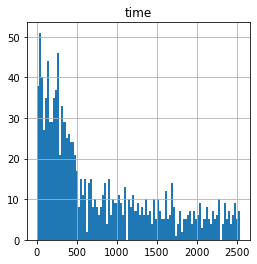

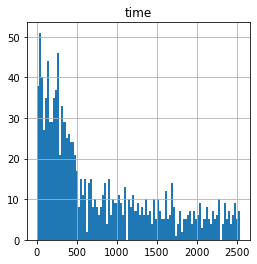

In [21]:
sm.zone_to_transit.groupby('direction').hist(column='time', bins=100, log=False, figsize=(4,4))

### Save model

In [24]:
sm.to_json(model_path + 'de_pt_access_egress',
           only_attributes=['centroids', 'footpaths', 'zone_to_transit'],
           encoding='utf-8')

to_hdf(overwriting): 100%|██████████████████████████████████████████████████████████████████| 33/33 [00:16<00:00,  1.99it/s]
